In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.model_selection import train_test_split

### Data Cleaning 

In [47]:
chiefs = pd.read_csv("ChiefsDataComplete_.csv")
chiefs.drop(chiefs.tail(1).index,inplace=True)

# drop last row because it's empty, it's what we need to predict values for
chiefs.shape

(55, 18)

In [48]:
# check for nulls
chiefs.isnull().sum()

TeamScore         0
Week              0
OppScore          0
1stD Offense      0
TotYd  Offense    0
PassY Offense     0
RushY Offense     0
TO Offense        1
1stD Defense      0
TotYd Defense     0
PassY Defense     0
RushY Defense     0
TO Defense        2
Offense           0
Defense           0
Sp. Tms           0
Season            0
Game              0
dtype: int64

In [49]:
# filling missing values w/ the mean of those columns 
chiefs['TO Offense'].fillna((chiefs['TO Offense'].mean()), inplace=True)
chiefs['TO Defense'].fillna((chiefs['TO Defense'].mean()), inplace=True)


In [50]:
chiefs.isnull().sum()

TeamScore         0
Week              0
OppScore          0
1stD Offense      0
TotYd  Offense    0
PassY Offense     0
RushY Offense     0
TO Offense        0
1stD Defense      0
TotYd Defense     0
PassY Defense     0
RushY Defense     0
TO Defense        0
Offense           0
Defense           0
Sp. Tms           0
Season            0
Game              0
dtype: int64

## Feature Selection (1)

In [51]:
X = chiefs.iloc[:,2:17]
y = chiefs.TeamScore

X.shape

(55, 15)

In [52]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# create Linear Regression Model
clf = LinearRegression()

# Build step forward feature selection
# decided k values based off of standard error plots
# k = 16 including all variables
sfs1 = sfs(clf,k_features = 15,forward=True,floating=False,scoring='neg_mean_squared_error',cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X, y)




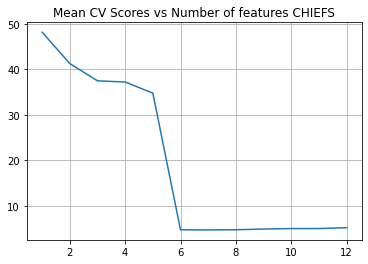

No of features= 6
[0, 5, 10, 11, 12, 13]
Features selected in forward fit
Index(['OppScore', 'TO Offense', 'TO Defense', 'Offense', 'Defense',
       'Sp. Tms'],
      dtype='object')


In [53]:
# https://www.r-bloggers.com/2017/10/practical-machine-learning-with-r-and-python-part-3/
a=sfs1.get_metric_dict()
n=[]
o=[]
# Compute the mean cross validation scores
for i in np.arange(1,13):
    n.append(-np.mean(a[i]['cv_scores']))  
    
m=np.arange(1,13)

# Get the index of the minimum CV score
# Plot the CV scores vs the number of features
fig1=plt.plot(m,n)
fig1=plt.title('Mean CV Scores vs Number of features CHIEFS')
fig1.figure.savefig('fig1.png', bbox_inches='tight')
plt.grid()
plt.show()


#print(pd.DataFrame.from_dict(sfs1.get_metric_dict(confidence_interval=0.90)).T)
idx = np.argmin(n)

print ("No of features=",idx)
#Get the features indices for the best forward fit and convert to list
b=list(a[idx]['feature_idx'])
print(b)
# Index the column names. 
# Features from forward fit
print("Features selected in forward fit")
print(X.columns[b])

# the table shows avgs for features, 10 fold CV errors
# the graph shows us that at 6 features we have the kowers mean CV error

In [54]:
#fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev') # high sd = low precision
#plt.title('Sequential Forward Selection (w. StdErr)')
#plt.grid()
#plt.show()

# y-axis represents

In [55]:
# don't have to do this part but i wanted it to look nicer printed
sfs2 = sfs(clf,k_features = 6,forward=True,floating=False,scoring='neg_mean_squared_error',cv=5)

# Perform SFFS
sfs2 = sfs2.fit(X, y)


In [56]:
# Index the column names. 
# Features from forward fit
print("Features selected in forward fit:")
print(sfs2.k_feature_names_)
print(sfs2.k_feature_idx_)

Features selected in forward fit:
('OppScore', 'TO Offense', 'TO Defense', 'Offense', 'Defense', 'Sp. Tms')
(0, 5, 10, 11, 12, 13)


### ETS for X inputs

In [57]:
X_LR = X.iloc[:, [0, 5, 10, 11, 12, 13]]
y_LR = y

X_LR.head()

,OppScore,TO Offense,TO Defense,Offense,Defense,Sp. Tms
0,28.0,0.0,2.0,13.10,-24.31,19.32
1,37.0,1.0,0.0,27.25,-26.79,10.45
2,27.0,0.0,0.0,29.69,-19.16,1.56
3,23.0,0.0,1.0,15.71,-8.63,-2.95
4,14.0,2.0,5.0,5.01,7.23,2.84


In [58]:
#corr = TB.corr()
#g = sns.heatmap(corr,  vmax=.3, center=0,
            #square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='PuOr')
#sns.despine()
#g.figure.set_size_inches(10,10)
    
#plt.show()

In [59]:
# create empty data frame that will append all predicted variables to it
etspred_KC = pd.DataFrame()

# create ETS model for each variable to be considered in the regression above
# fit those models and forecast out by one step
for i in X_LR:
    X = X_LR[i]
    model = SimpleExpSmoothing(np.asarray(X))
    fit = model.fit()
    fit = fit.forecast(1)
    etspred_KC[i] = fit

# round each number so we have whole numbers only
for i in etspred_KC:
    etspred_KC[i] = round(etspred_KC[i])
    

    

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [60]:
# set week to 20 
etspred_KC['Week'] = 20
etspred_KC = etspred_KC[['Week', 'OppScore', 'TO Offense', 'TO Defense', 'Offense', 'Defense', 'Sp. Tms']]
etspred_KC


,Week,OppScore,TO Offense,TO Defense,Offense,Defense,Sp. Tms
0,20,23.0,1.0,2.0,16.0,-6.0,-1.0


## Linear Regression (1)

In [61]:
# want to reinclude week in the regression
X = chiefs.iloc[:,1:17]
X_LR = X.iloc[:,[0, 1, 6, 11, 12, 13, 14]]
y_LR = y
X_LR.columns

Index(['Week', 'OppScore', 'TO Offense', 'TO Defense', 'Offense', 'Defense',
       'Sp. Tms'],
      dtype='object')

In [62]:
# use training and testing data so we can get some accuracy measures such as R_2 and MSE
X_train, X_test, y_train, y_test = train_test_split(
         X_LR, y_LR, test_size=0.33, random_state=1)

In [63]:
from sklearn.linear_model import LinearRegression

# create OLS - Linear regression model on training data
model = LinearRegression()

model.fit(X_train, y_train)

# make predictions w/ testing data
predictions = model.predict(X_test)

#model.summary()




In [64]:
coeff = list(zip(model.coef_, ['Week', 'OppScore', 'TO Offense', 'TO Defense', 'Offense', 'Defense',
       'Sp. Tms']))

for i in coeff: 
    print(i)

(0.051951081226269534, 'Week')
(0.9144137252055222, 'OppScore')
(0.2526524068934593, 'TO Offense')
(0.41148357048442574, 'TO Defense')
(0.9189547374050214, 'Offense')
(0.9387091131892441, 'Defense')
(0.8996779643389541, 'Sp. Tms')


In [65]:
from sklearn import metrics
from sklearn.metrics import r2_score 

from sklearn.metrics import mean_squared_error  

# Calculation of Mean Squared Error (MSE) 
print("MSE: ", mean_squared_error(y_test, predictions) )

# calculate MAPE
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print("MAPE: ", MAPE(y_test, predictions))


print("R_2: ", r2_score(y_test, predictions))

MSE:  4.3700698494284635
MAPE:  6.0665444146096466
R_2:  0.9183523850717485


In [66]:
final_score = model.predict(etspred_KC)
np.round(final_score)[0]

32.0